# Stroke Prediction

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from pyGRNN import GRNN
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn import tree
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
import warnings
warnings.filterwarnings(action='ignore')
from sklearn.metrics import plot_confusion_matrix
from matplotlib.pyplot import figure
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.tree import plot_tree
import seaborn as sns
from itertools import product

### Stroke Dataset
link: https://www.kaggle.com/fedesoriano/stroke-prediction-dataset

In [2]:
# load dataset
df = pd.read_csv("healthcare-dataset-stroke-data.csv")

# Data Processing

In [3]:
# check data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [4]:
# check missing values by column in stroke data 
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [5]:
# count gender 
df["gender"].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [6]:
# do not select Other in gender column 
df = df[df['gender'] != "Other"]
df["gender"].value_counts()

Female    2994
Male      2115
Name: gender, dtype: int64

In [7]:
# drop id column
df.drop("id", axis = 1, inplace = True)

In [8]:
# column names
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

### Handle missing values

<AxesSubplot:xlabel='bmi', ylabel='Density'>

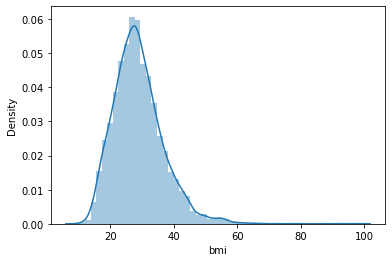

In [9]:
# density plot for BMI
sns.distplot(df[df['bmi'].notnull()]['bmi'])

In [10]:
# replace missing in BMI with mean value of column
df['bmi'].fillna((df['bmi'].mean()), inplace=True)

# EDA

### Analysis of People who have stroke 

In [11]:
# percentage of male get stroke 
female_perc = 100 * df.groupby(["gender"])['stroke'].sum()[0]/df.gender.value_counts()[0]
# percentage of female get stroke
male_perc = 100 * df.groupby(["gender"])['stroke'].sum()[1]/df.gender.value_counts()[1]

# create a sub data frame
sub1 = {'male_stroke': male_perc, 'female_stroke': female_perc}
sub1 = pd.DataFrame(data=sub1, index = [0])

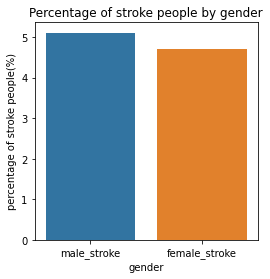

In [12]:
# plot percentage of male get stroke and percentage of female get stroke
plt.figure(figsize=(4,4))
sns.barplot(data=sub1).set(xlabel='gender', ylabel='percentage of stroke people(%)', title = "Percentage of stroke people by gender")
plt.show()

#### Male has a higher chance to get stroke than female. 

In [13]:
# Percentage of stroke people by smoking_status
sub2 = 100 * df.groupby(["smoking_status"])['stroke'].sum()/df.smoking_status.value_counts()
# create a sub data frame
sub2 = {'Unkown': sub2[0], 'formerly smoke': sub2[1], "never smoked": sub2[2], "smokes": sub2[3]}
sub2 = pd.DataFrame(data=sub2, index = [0])

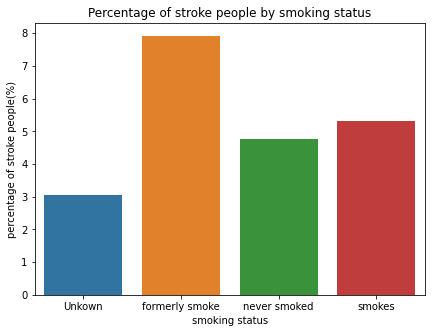

In [14]:
# plot stroke by smoking_status
plt.figure(figsize=(7,5))
sns.barplot(data=sub2).set(xlabel='smoking status', ylabel='percentage of stroke people(%)', title = "Percentage of stroke people by smoking status")
plt.show()

#### People who smoke are more likely to get stroke than people who do not smoke.

In [15]:
100 * df.groupby(["smoking_status"])['stroke'].sum()/df.smoking_status.value_counts()

Unknown            3.044041
formerly smoked    7.918552
never smoked       4.756871
smokes             5.323194
dtype: float64

In [16]:
# Percentage of stroke people by work type
sub3 = 100 * df.groupby(["work_type"])['stroke'].sum()/df.work_type.value_counts()
# create a sub data frame
sub3 = {'Govt_job': sub3[0], 'Never_worked': sub3[1], "Private": sub3[2], "Self_employed": sub3[3], "children": sub3[4]}
sub3 = pd.DataFrame(data=sub3, index = [0])

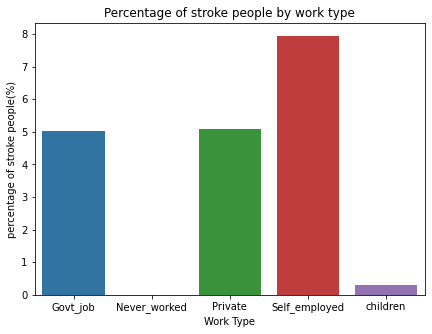

In [17]:
# plot stroke by work type
plt.figure(figsize=(7,5))
sns.barplot(data=sub3).set(xlabel='Work Type', ylabel='percentage of stroke people(%)', title = "Percentage of stroke people by work type")
plt.show()

#### Most people who have stroke decide to self-employed. 

In [18]:
100 * df.groupby(["work_type"])['stroke'].sum()/df.work_type.value_counts()

Govt_job         5.022831
Never_worked     0.000000
Private          5.095759
Self-employed    7.936508
children         0.291121
dtype: float64

In [19]:
# percentage of urban people get stroke 
rural_perc = 100 * df.groupby(["Residence_type"])['stroke'].sum()[0]/df.Residence_type.value_counts()[1]
# percentage of rural people get stroke 
urban_perc = 100 * df.groupby(["Residence_type"])['stroke'].sum()[1]/df.Residence_type.value_counts()[0]

# create a sub data frame
sub4 = {'rural_stroke': rural_perc, 'urban_stroke': urban_perc}
sub4 = pd.DataFrame(data=sub4, index = [0])

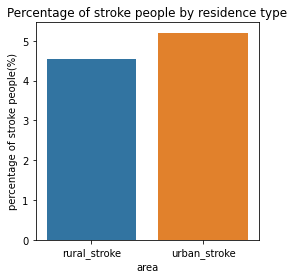

In [20]:
# plot percentage of urban people get stroke and percentage of rural people get strok
plt.figure(figsize=(4,4))
sns.barplot(data=sub4).set(xlabel='area', ylabel='percentage of stroke people(%)', title = "Percentage of stroke people by residence type")
plt.show()

#### People who live in urban area are more likely to get stroke.

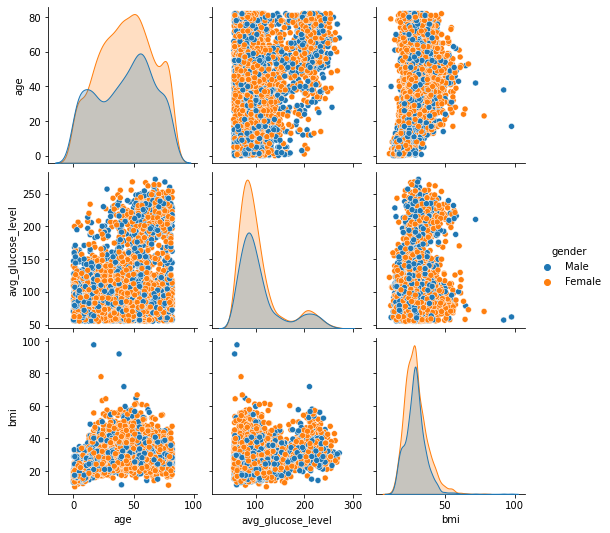

In [21]:
# Extract numeric columns and gender 
df_numeric = df[["age", "avg_glucose_level", "bmi", "gender"]]
# scatterplot matrix for numeric variables 
sns.pairplot(df_numeric, hue = "gender")

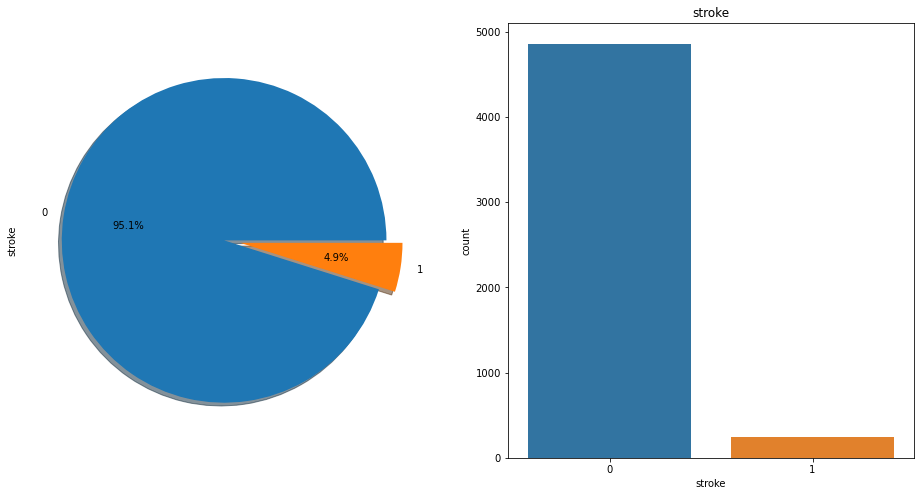

In [22]:
# percentages and counts of people who stroke vs non-stroke 
f,ax=plt.subplots(1,2,figsize=(16,8))
df['stroke'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
sns.countplot('stroke',data=df,ax=ax[1])
ax[1].set_title('stroke')
plt.show()

<AxesSubplot:xlabel='stroke', ylabel='Density'>

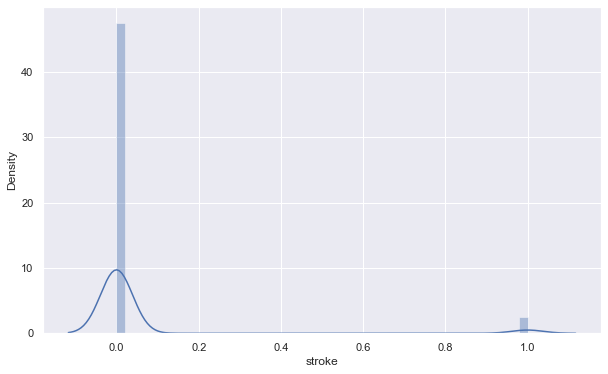

In [23]:
# density plot of Stroke 
sns.set(rc={'figure.figsize':(10,6)})
sns.distplot(df['stroke'])

In [24]:
# count of 0.0 and 1.0 before smote
print(df.stroke.value_counts()[0])
print(df.stroke.value_counts()[1])

4860
249


In [25]:
# ratio of 0.0 to 1.0 in stroke column
df.stroke.value_counts()[0]/df.stroke.value_counts()[1]

19.518072289156628

#### The density plot shows that the target variable "stroke" has an uneven distribution of observations. Class 0 has a very high number of observations and Class 1 has a very low number of observations. To deal with the imbalanced data, we will use SMOTE oversampling technique to generate random samples from minority class.  

## Compute Correlation Matrix

In [26]:
# correlation matrix for checking collinearity
corrMatrix = df.corr()
corrMatrix = round(corrMatrix,2)
corrMatrix

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
age,1.00,0.28,0.26,0.24,0.33,0.25
hypertension,0.28,1.00,0.11,0.17,0.16,0.13
heart_disease,0.26,0.11,1.00,0.16,0.04,0.13
avg_glucose_level,0.24,0.17,0.16,1.00,0.17,0.13
bmi,0.33,0.16,0.04,0.17,1.00,0.04
stroke,0.25,0.13,0.13,0.13,0.04,1.00


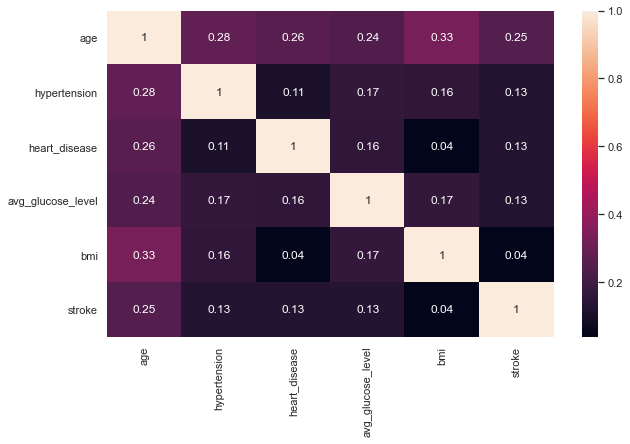

In [27]:
# heatmap displaying correlation Matrix 
sns.heatmap(corrMatrix, annot=True)
sns.set(rc={'figure.figsize':(20,10)})

#### From the correlation matrix plot, we find that there is no strong correlation among variables. 

# Feature Engineering

### 1. Encode categorical variables 

In [28]:
 # dummy code gender column 
df['is_female'] = df['gender'].apply(lambda x:1 if x == "Female"else 0)
# drop gender column 
df.drop("gender", axis = 1, inplace = True)

In [29]:
 # dummy code ever_married column 
df['is_married'] = df['ever_married'].apply(lambda x:1 if x == "Yes"else 0)
# drop gender column 
df.drop("ever_married", axis = 1, inplace = True)

In [30]:
 # dummy code Residence_type
df['is_urban'] = df['Residence_type'].apply(lambda x:1 if x == "Urban"else 0)
# drop gender column 
df.drop("Residence_type", axis = 1, inplace = True)

In [31]:
df = pd.get_dummies(df)
df.columns

Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'stroke', 'is_female', 'is_married', 'is_urban', 'work_type_Govt_job',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children',
       'smoking_status_Unknown', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes'],
      dtype='object')

In [32]:
# Split into two datasets, one with predictors, one with response
X, y = df.drop(['stroke'], axis = 1), df['stroke']

In [33]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 0 to 5109
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             5109 non-null   float64
 1   hypertension                    5109 non-null   int64  
 2   heart_disease                   5109 non-null   int64  
 3   avg_glucose_level               5109 non-null   float64
 4   bmi                             5109 non-null   float64
 5   is_female                       5109 non-null   int64  
 6   is_married                      5109 non-null   int64  
 7   is_urban                        5109 non-null   int64  
 8   work_type_Govt_job              5109 non-null   uint8  
 9   work_type_Never_worked          5109 non-null   uint8  
 10  work_type_Private               5109 non-null   uint8  
 11  work_type_Self-employed         5109 non-null   uint8  
 12  work_type_children              51

In [34]:
# change y to data frame
y = pd.DataFrame(y)

### 3. SMOTE for data balancing 

In [35]:
# SMOTE for data balancing
sm = SMOTE(random_state=12)
X, y = sm.fit_resample(X, y)

<AxesSubplot:xlabel='stroke', ylabel='Density'>

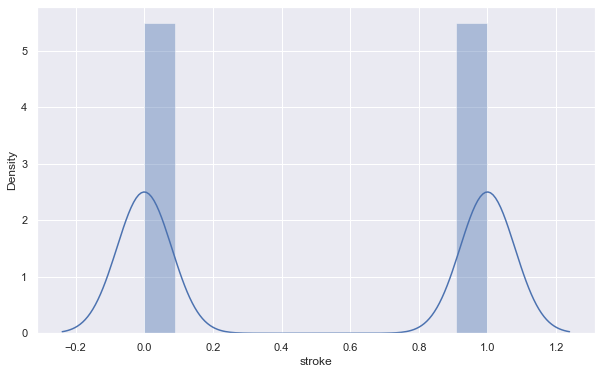

In [36]:
# density plot of stroke after balancing 
sns.set(rc={'figure.figsize':(10,6)})
sns.distplot(y['stroke'])

In [37]:
# count 0.0 and 1.0 
print(y.stroke.value_counts()[0])
print(y.stroke.value_counts()[1])

4860
4860


In [38]:
# ratio of 0.0 to 1.0
y.stroke.value_counts()[0]/y.stroke.value_counts()[1]

1.0

#### Now the data is balanced

# Models

## Logistic regression 

In [39]:
# Split data into train and test
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size = 0.8, test_size = 0.2, stratify=y)

In [40]:
# cross validation on training data 
model = LogisticRegression()
scores = cross_val_score(model, train_X, train_y, cv=10,scoring='accuracy')

In [41]:
# accuracy 
np.mean(scores)

0.9252804769514281

In [42]:
# predicted stroke rate
model.fit(train_X, train_y)
y_pred_logit = model.predict(test_X)

In [43]:
# shape of predicted stroke rate
y_pred_logit.shape

(1944,)

In [44]:
# compare actual stroke in test with predicted stroke rate (prediction accuracy)
accuracy_metric = accuracy_score(y_pred_logit, test_y)
accuracy_metric

0.926440329218107

##### The cv accuracy and the prediction accuracy are roughly equal. So the logistic model has no issue of overfitting. 

### Logistic Regression Confusion Matrix

<Figure size 6400x4800 with 0 Axes>

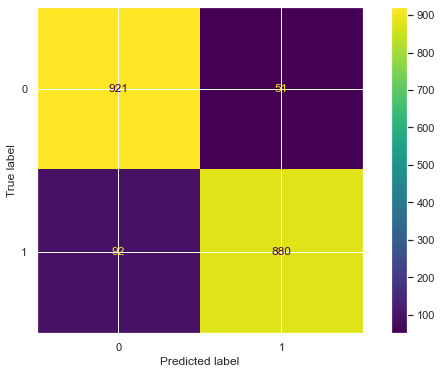

In [45]:
# confusion matrix 
figure(figsize=(80, 60), dpi=80)
plot_confusion_matrix(model, test_X, test_y) 
plt.show()

## ROC Curve for logistic regression

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.978


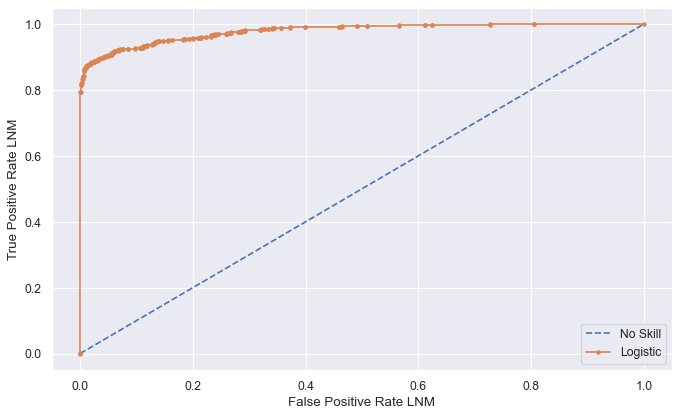

In [46]:
# roc curve and auc
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(test_y))]
# fit a model
model.fit(train_X, train_y)
# predict probabilities
lr_probs = model.predict_proba(test_X)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(test_y, ns_probs)
lr_auc = roc_auc_score(test_y, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(test_y, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(test_y, lr_probs)


figure(figsize=(10, 6), dpi=80)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate LNM')
pyplot.ylabel('True Positive Rate LNM')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

### The ROC curve shows the trade-off between sensitivity (or TPR) and specificity (1 – FPR). Classifiers that give curves closer to the top-left corner indicate a better performance. In our plot, the curve is really close to the left- upper corner. Thus, our performance is very ideal. 

## Decision Tree
Since Decision Tree is not impacted by multicollinearity issue, so we apply pre-pca data to train model.

In [47]:
# cross validation on training data 
dtree = DecisionTreeClassifier()
dtree_scores_pca = cross_val_score(dtree, train_X, train_y, cv=10, scoring='accuracy')
# crosss validation accuracy 
np.mean(dtree_scores_pca)

0.9395549423827058

In [48]:
# compute prediction accuracy
d_fit = dtree.fit(train_X, train_y)
y_pred = dtree.predict(test_X)
accuracy_metric = accuracy_score(y_pred, test_y)
accuracy_metric

0.9367283950617284

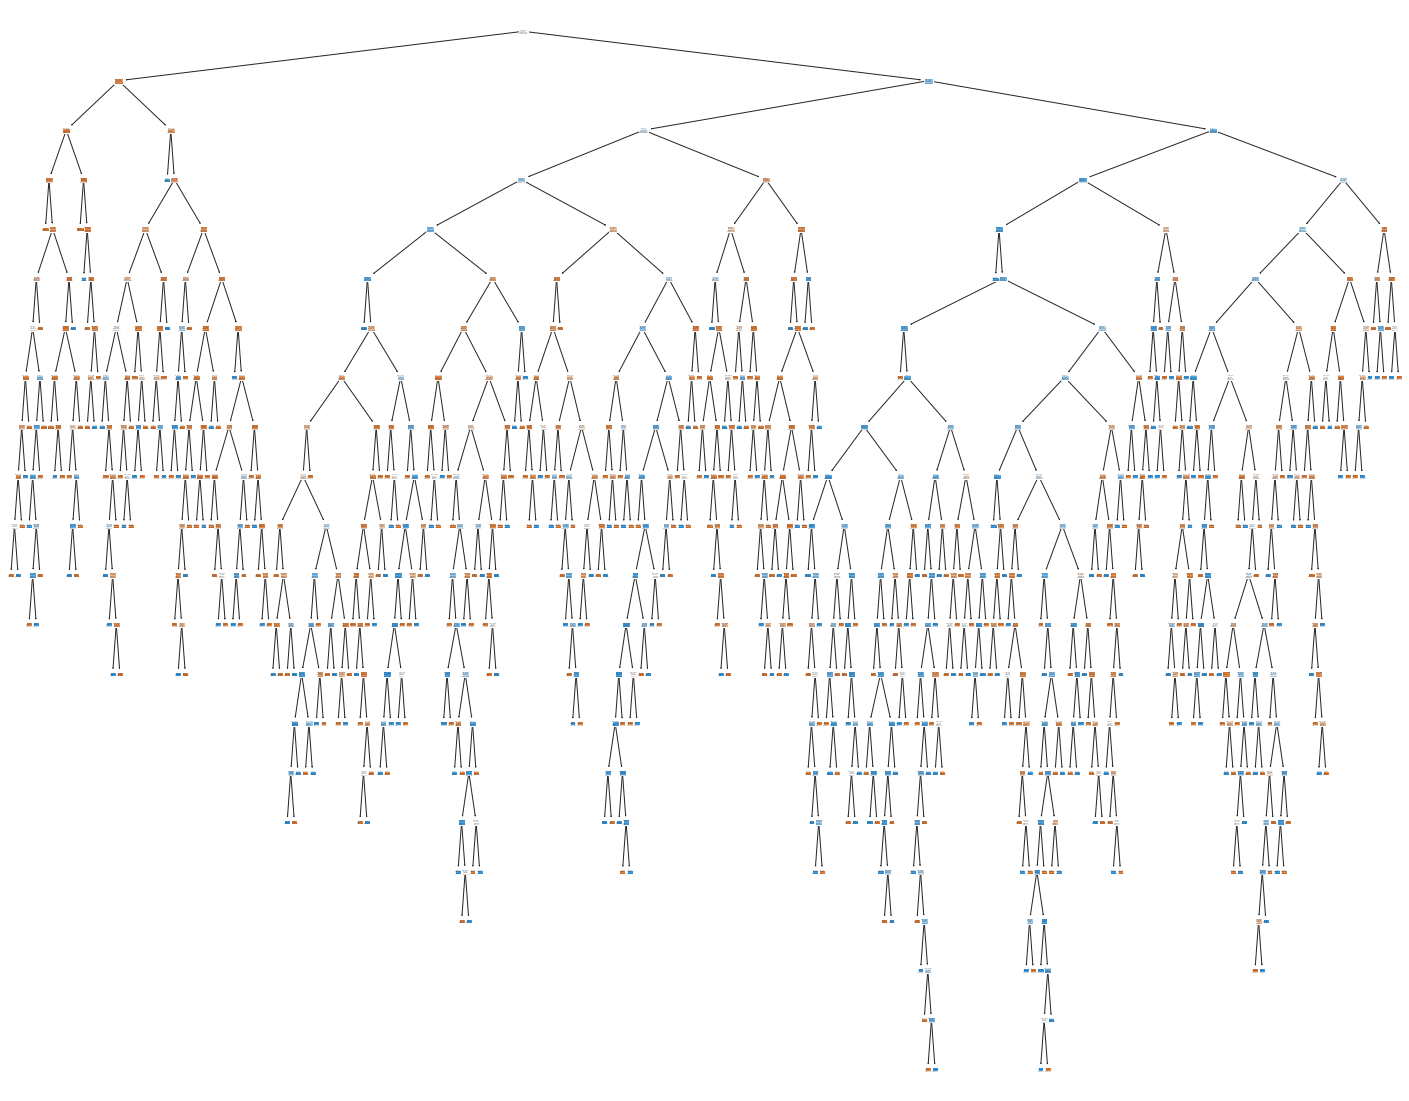

In [49]:
# tree plot
fig = plt.figure(figsize=(25,20))
plot_tree(dtree.fit(train_X, train_y), filled=True)
plt.show()

## Random Forest

In [50]:
# cross validation on pre-PCA training data 
rf = RandomForestClassifier()
rf_scores = cross_val_score(rf, train_X, train_y, cv=10, scoring='accuracy')
# crosss validation accuracy 
np.mean(rf_scores)

0.9682355510119006

In [51]:
# comput prediction accuracy
rf.fit(train_X, train_y)
y_pred = rf.predict(test_X)
accuracy_metric = accuracy_score(y_pred, test_y)
accuracy_metric

0.9665637860082305

Text(0.5, 0.98, 'Important Variables From Random Forest')

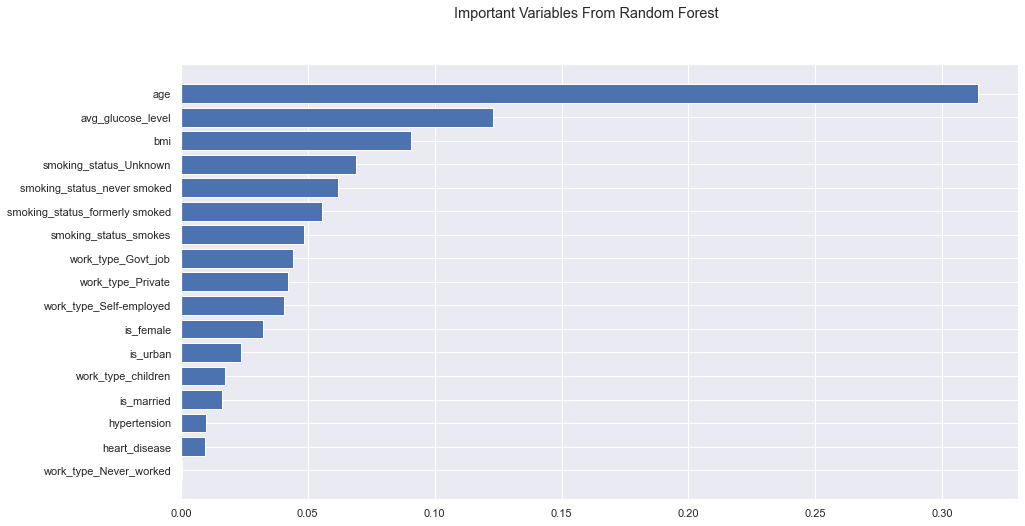

In [52]:
# Top 20 most important features of this model
sorted_idx = rf.feature_importances_.argsort()[-20:]
plt.figure(figsize=(15,8))
plt.barh(train_X.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.suptitle('Important Variables From Random Forest')

#### Since prediction accuracy and cv accuacy are similar, the model has no overfitting issue.

## Nerual Network: GRNN

In [53]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error as MSE
import warnings
warnings.filterwarnings("ignore")

grnn = GRNN()
# Define the parameters for a GridSearch CV and fit the model
params_grnn = {'kernel':["RBF"],
                'sigma' : list(np.arange(0, 20, 0.1)),
                'calibration' : ['None']
                 }
grid_grnn = GridSearchCV(estimator=grnn,
                          param_grid=params_grnn,
                          scoring='neg_mean_squared_error',
                          cv=5,
                          verbose=1,
                          n_jobs = -1
                          )
grid_grnn.fit(train_X, train_y.values.ravel())
# Use the best model to perform prediction, and compute mse
best_model = grid_grnn.best_estimator_
y_pred = best_model.predict(test_X)
y_pred = list(map(lambda x: 1 if x >0.5 else 0 ,y_pred))
accuracy_metric = accuracy_score(y_pred, test_y)
accuracy_metric

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


0.9161522633744856

In [54]:
grid_grnn.best_params_

{'calibration': 'None', 'kernel': 'RBF', 'sigma': 0.1}

##### The model accuracy at sigma = 0.9 is the highest at 91.2% 

In [55]:
ypred = cross_val_predict(best_model, X, y, cv=6)
ypred

array([1., 1., 1., ..., 1., 1., 1.])

In [56]:
y_pred = list(map(lambda x: 1 if x >0.5 else 0 ,ypred))


In [57]:
accuracy_metric = accuracy_score(y_pred, y)
accuracy_metric

0.9145061728395062

Does not seem it is overfitting as cross-validation accuracy score is also around 90%. 